In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess

In [42]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [87]:
df = pd.read_csv('image_clustering/siamese_vienna_codes/vienna.csv')

In [88]:
df.head()

,application_no,vienna_code
0,5047665,"270501, 290112"
1,5076365,"270501, 290112"
2,5009636,"260101, 270501, 290112"
3,5039085,"270501, 290112"
4,5045779,"030201, 290108, 270501"


In [8]:
application_numbers = df['application_no'][:10].tolist()

In [121]:
def get_image_from_s3(application_num,directory="."):
    image_name = str(application_num)+".png"
    if not os.path.exists(directory):
        os.makedirs(directory)
    exit_code = subprocess.call(['./aws_s3_get_image.sh',image_name,directory])
    if exit_code==0:
        print("download success")


In [122]:
get_image_from_s3(5076365,"s3_downloads")

download success


In [22]:
!ls

101_ObjectCategories          image-similarity
101_ObjectCategories.tar.gz   image_clustering
Untitled.ipynb                image_similarity.py
aws_s3_get_image.sh           image_similarity_api.csv
caltech-101.sframe            image_similarity_resnet.ipynb
data                          image_similarity_v2.ipynb
google_image_search           image_similarity_v3.ipynb
hierarchical_clustering.ipynb images
holiday-similarity            research_papers


In [24]:
!aws s3 cp s3://tmwatch/vienna/5047665.png s3_downloads

download: s3://tmwatch/vienna/5047665.png to s3_downloads/5047665.png


### Setting data for Hierarchical Clutestering

In [66]:
df.dtypes

application_no        int64
vienna_codes_list    object
dtype: object

In [83]:
def get_list(row):
    vienna_code_str = row['vienna_code'].split(',')
    vienna_code_int = [int(code) for code in vienna_code_str if code!='Error']
    return vienna_code_int

In [89]:
df['vienna_code_list'] = df.apply(get_list,axis=1)

In [40]:
df.drop('vienna_code',axis=1,inplace=True)

In [90]:
df.head()

,application_no,vienna_code,vienna_code_list
0,5047665,"270501, 290112","[270501, 290112]"
1,5076365,"270501, 290112","[270501, 290112]"
2,5009636,"260101, 270501, 290112","[260101, 270501, 290112]"
3,5039085,"270501, 290112","[270501, 290112]"
4,5045779,"030201, 290108, 270501","[30201, 290108, 270501]"


In [52]:
df[df['application_no']==5047665].vienna_codes_list

0    [270501,  290112]
Name: vienna_codes_list, dtype: object

In [92]:
df_new = pd.DataFrame(mlb.fit_transform(df.vienna_code_list),columns=mlb.classes_)

In [94]:
df_final  = pd.concat([df,df_new],axis=1)

In [103]:
df_final.to_csv('image_clustering/siamese_vienna_codes/vienna_code_one_hot_encoded.csv')

In [105]:
df_final[df_final['application_no']==5076365][[270501,290112]]

,270501,290112
1,1,1


In [104]:
df_final.head()

,application_no,vienna_code,vienna_code_list,10101,10102,10103,10105,10110,10112,10125,...,290103,290104,290105,290107,290108,290111,290112,290113,290114,290115
0,5047665,"270501, 290112","[270501, 290112]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,5076365,"270501, 290112","[270501, 290112]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,5009636,"260101, 270501, 290112","[260101, 270501, 290112]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,5039085,"270501, 290112","[270501, 290112]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5045779,"030201, 290108, 270501","[30201, 290108, 270501]",0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


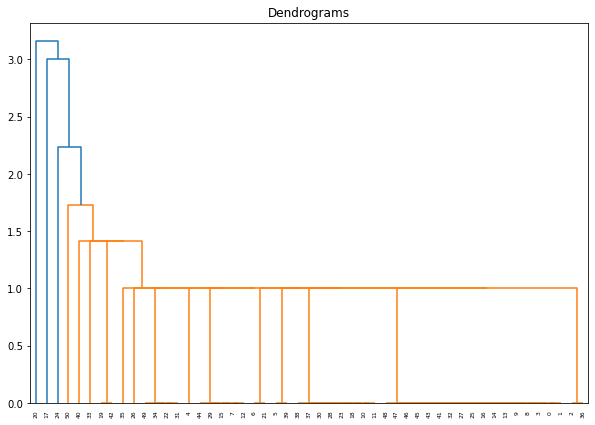

In [111]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df_final.loc[:50].drop(['application_no','vienna_code','vienna_code_list'],axis=1)))




In [114]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(distance_threshold=1,n_clusters=None, affinity='euclidean', linkage='average')  
cluster_num = cluster.fit_predict(df_final.drop(['application_no','vienna_code','vienna_code_list'],axis=1))

In [115]:
cluster_num

array([ 94,  94,  40, ..., 145, 102, 113])

In [116]:
df_results = df_final[['application_no','vienna_code_list']]

In [117]:
df_results['cluster_id'] = cluster_num

<ipython-input-117-326a076ff817>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['cluster_id'] = cluster_num


In [119]:
df_results.cluster_id.nunique()

473

In [127]:
unique_clusters = df_results.cluster_id.unique().tolist()

In [126]:
df_results.head()

,application_no,vienna_code_list,cluster_id
0,5047665,"[270501, 290112]",94
1,5076365,"[270501, 290112]",94
2,5009636,"[260101, 270501, 290112]",40
3,5039085,"[270501, 290112]",94
4,5045779,"[30201, 290108, 270501]",472


In [125]:
def download_image_for_given_cluster(cluster_id):
    df_temp = df_results[df_results['cluster_id']==cluster_id]
#     print(df_temp)
    app_nums = df_temp.application_no.tolist()
    directory = "cluster_{}".format(cluster_id)
    for app_num in app_nums:
        get_image_from_s3(app_num,directory)

In [161]:
for cluster in cluster_with_less_than_10_images:
    if cluster!=94:
        download_image_for_given_cluster(cluster)

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

In [129]:
df_results[df_results['cluster_id']==94]

,application_no,vienna_code_list,cluster_id
0,5047665,"[270501, 290112]",94
1,5076365,"[270501, 290112]",94
3,5039085,"[270501, 290112]",94
8,5022776,"[270501, 290112]",94
9,5053408,"[270501, 290112]",94
...,...,...,...
9595,5015368,"[270501, 290112]",94
9603,5005060,"[270501, 290112]",94
9605,5027715,"[270501, 290112]",94
9608,5038659,"[270501, 290112]",94


In [151]:
df_cluster_count = df_results.groupby('cluster_id')['application_no'].count().reset_index().sort_values(by='application_no',ascending=False)

In [130]:
df_results.shape

(9614, 3)

In [131]:
### 37.68% of data is tagged with [[270501, 290112]] which represent form of writing and color

0.3767422508841273

In [152]:
df_cluster_count.columns = ['cluster_id', 'count_of_images']

In [153]:
df_cluster_count.dtypes

cluster_id         int64
count_of_images    int64
dtype: object

In [159]:
cluster_with_less_than_10_images = df_cluster_count[df_cluster_count['count_of_images']<=10].cluster_id.unique().tolist()

In [155]:
df_cluster_count.describe()

,cluster_id,count_of_images
count,473.0000,473.000000
mean,236.0000,20.325581
std,136.6876,184.100193
min,0.0000,1.000000
25%,118.0000,1.000000
50%,236.0000,1.000000
75%,354.0000,2.000000
max,472.0000,3622.000000


### Using turicreate for image-similarity
#### Turicreate has failed

### Create images for labelling

In [35]:
df_images = pd.read_csv('fileaa.txt',header=None)

In [36]:
df_images = df_images.iloc[:,0].str.split().reset_index()

In [63]:
df_images.shape

(10000, 2)

In [55]:
def get_image_name(row):
    return(str(row.iloc[1][1]))

In [56]:
df_image_names = df_images.apply(get_image_name,axis=1)

In [34]:
df_images.iloc[:,0].str.split()[:1]

['2771', '3000701.png']

In [59]:
image_list = df_image_names.tolist()

In [60]:
def get_image_from_s3(application_num,directory="."):
    image_name = application_num
    if not os.path.exists(directory):
        os.makedirs(directory)
    exit_code = subprocess.call(['./aws_s3_get_image.sh',image_name,directory])
    if exit_code==0:
        print("download success")

In [64]:
for image in image_list:
    get_image_from_s3(image,'first_set')

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download success
download succe

### SIFT (Scale Invariant Feature Transformation)

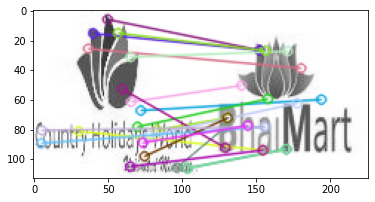

(<matplotlib.image.AxesImage at 0x7fa18ba02340>, None)

In [2]:

import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

# read images
img1 = cv2.imread('cluster_26/5006674.png')  
img2 = cv2.imread('cluster_26/5029567.png') 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.imshow(img3),plt.show()

In [14]:
len(matches)

20

In [68]:
!pip install opencv-contrib-python


     |████████████████████████████████| 51.4 MB 5.5 MB/s eta 0:00:01


In [8]:
descriptors_1.shape

(79, 128)

In [9]:
descriptors_2.shape

(93, 128)

In [12]:
matches[0].distance

104.0

In [4]:
img = cv2.imread('cluster_26/5006674.png')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create(nfeatures=2000)
kp, des = orb.detectAndCompute(gray_img, None)

kp_img = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)

cv2.imshow('ORB', kp_img),plt.show()

(None, None)